# Info
This is the main answer to this project. Below is where all findings are accumulated to give the most accurate answers. To see progression and how the params are found read README.txt.

# 1. Functions for generating synthetic input data

## Libraries

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import random as rnd
from datetime import datetime as dt

## Example functions

In [8]:
def F2(y):
    return 0.5*y**2


def Fcos(y):
    return 1 - np.cos(y)


def F22(y1, y2):
    return 0.5*(y1**2 + y2**2)


def Fsqrt(y1, y2):
    return - 1 / np.sqrt(y1**2 + y2**2)

## Numerical functions for Hamiltonian systems

In [9]:
# We wish to find how qn, pn changes with n, and therefore how the hamiltonian changes
# along the n-values


# Examples of seperable Hamiltonian problems
# T:The kinetic energy
# V:The potensial energy


# T and V for the hamiltonian in nonlinear pendelum
def T_H_1(p):
    return (1/2)*p**2


def V_H_1(q):
    return m*g*l*(1-np.cos(q))

# T and V for the Hamiltonian in Kepler's two-body problem


def T_H_2(x):
    return (1/2)*np.dot(np.transpose(x), x)


def V_H_2(y):
    return -((1)/(np.sqrt(y[0]**2+y[1]**2)))

# T and V for the Hamiltonian in Henon-heile's problem


def T_H_3(p):
    return (1/2)*np.dot(np.transpose(p), p)


def V_H_3(q):
    return (1/2)*np.dot(np.transpose(q), q)+(q[0]**2)*q[1]-(1/3)*q[1]**3


# 2. Implementation of the neural network and optimizers

In [10]:
def σ(x):
    return np.tanh(x)


def dσ(x):
    # return 1 / np.cosh(x)**2 # our
    return 1.0 - np.tanh(x) ** 2


def η(x):  # max [0, 1]
    return (1.0 + np.tanh(x / 2.0)) / 2.0


def dη(x):
    # return 1/(2 * np.cosh(x) + 2) # our
    return 0.25 * (1.0 - np.tanh(x / 2.0) ** 2)


class Model():
    """Base model:
        It holds startup informasjon about the model and the network used in this method.
    """

    def __init__(self, Y0, C, K, weigths=None):
        """Set values"""
        self.d = len(Y0)
        self.I = len(Y0[0])
        self.C = C  # Ska denna vær init her?
        self.K = K
        self.h = None
        self.j = 0  # Iterations
        self.Υ = np.zeros_like(self.C)
        self.Y0 = Y0
        self.ΥmC = self.Υ - self.C
        self.Jθ = 0.5 * np.linalg.norm(self.Υ - self.C)**2
        self.Jθlog = []
        if weigths:  # Imports weigths
            self.startθ = weigths
        else:  # set random weights
            self.startθ = {'W': np.random.rand(self.K, self.d, self.d),
                           'b': np.random.rand(self.K, self.d, 1),
                           'w': np.random.rand(self.d, 1),
                           'μ': np.random.rand()}
        """Memory allocation"""
        self.θ = self.copyWeights(self.startθ)
        self.Z = np.zeros((K+1, self.d, self.I))
        self.Z[0] = Y0
        # One less than intended bc P[0] is not used
        self.P = np.zeros((K, self.d, self.I))
        self.dθ = {'W': np.zeros((self.K, self.d, self.d)),
                   'b': np.zeros((self.K, self.d, 1)),
                   'w': np.zeros((self.d, 1)),
                   'μ': 0}

    def __repr__(self):
        pass

    def __len__(self):
        return self.I

    def copyWeights(self, weights):
        θ = {'W': weights['W'].copy(),
             'b': weights['b'].copy(),
             'w': weights['w'].copy(),
             'μ': weights['μ']}
        return θ

    def copy(self):
        θ = self.copyWeights(self.θ)
        return Model(self.Y0.copy(), self.C.copy(), self.K, θ)

    def computeZ(self, W, b, h, K):  # (4)
        for k in range(K):
            self.Z[k+1] = self.Z[k] + h * σ(W[k] @ self.Z[k] + b[k])

    def backwardPropagation(self, W, b, w, μ, Z, h, K):
        # Save computation
        Zxw = Z[-1].T @ w + μ
        # Update variables (Approximation)
        self.Υ = η(Zxw).T  # (5)
        self.ΥmC = self.Υ - self.C
        self.Jθ = 0.5*np.linalg.norm(self.ΥmC)**2
        # Compute last P[K]
        self.P[self.K-1] = np.outer(w, (self.ΥmC * dη(Zxw).T))  # (10) (verified)
        """Backward propagation"""
        for k in range(K-1, 0, -1):  # Change P index to K+1
            self.P[k-1] = self.P[k] + h*W[k].T @ (dσ(W[k] @ Z[k] + b[k]) * self.P[k])  # (11)

    def computeGradients(self, W, b, w, μ, Z, P, h, K):
        # save computation
        dηZw = dη(Z[K].T @ w + μ)
        # compute (8) and (9)
        self.dθ['μ'] = dηZw.T @ self.ΥmC.T
        self.dθ['w'] = Z[K] @ (self.ΥmC.T * dηZw)
        # Compute (12) and (13)
        for k in range(K):
            # Save computation
            PhadσWZ = h * P[k] * dσ(W[k] @ Z[k] + b[k])
            self.dθ['W'][k] = PhadσWZ @ Z[k].T
            self.dθ['b'][k] = PhadσWZ @ np.ones((self.I, 1))

    def update(self):
        self.computeZ(self.θ['W'], self.θ['b'], self.h, self.K)
        self.backwardPropagation(self.θ['W'], self.θ['b'], self.θ['w'],
                                 self.θ['μ'], self.Z, self.h, self.K)
        self.computeGradients(self.θ['W'], self.θ['b'], self.θ['w'],
                              self.θ['μ'], self.Z, self.P, self.h, self.K)

    def setInput(self, Y0, C):
        self.Y0 = Y0.copy()
        self.d = len(Y0)
        self.I = len(Y0[0])
        self.Z = np.zeros((self.K+1, self.d, self.I))
        self.Z[0] = Y0.copy()
        self.P = np.zeros((self.K, self.d, self.I))
        self.C = C.copy()
        self.Υ = np.zeros_like(self.C)
        self.ΥmC = self.Υ - self.C
        self.Jθ = 0.5 * np.linalg.norm(self.Υ - self.C)**2
        self.j = 0

    def restart(self):
        self.θ = self.copyWeights(self.startθ)
        self.j = 0
        self.Υ = np.zeros_like(self.C)
        self.ΥmC = self.Υ - self.C
        self.Jθ = 0.5 * np.linalg.norm(self.Υ - self.C)**2

    def gradTest(self, Y0):
        Z = np.zeros_like(self.Z)
        Z[0] = Y0

    def getGrads(self, Z):
        h = self.h
        K = self.K
        W = self.θ['W']
        b = self.θ['b']
        w = self.θ['w']
        μ = self.θ['μ']
        Z = self.Z.copy()

        # algorithm
        A = np.dot(w, dη(np.dot(w.T, Z[K]) + μ))
        for k in range(K, 0, -1):
            A = A + W[k-1].T @ (h * dσ(W[k-1] @ Z[k-1] + b[k-1]) * A)
        return A


class Adam():
    def __init__(self, model, h=None, tol=None, maxiter=None):
        self.M = model
        self.M.h = h
        self.tol = tol
        self.maxiter = maxiter
        self.m = {'W': np.zeros((model.K, model.d, model.d)),
                  'b': np.zeros((model.K, model.d, 1)),
                  'w': np.zeros((model.d, 1)),
                  'μ': 0}
        self.v = self.m.copy()

    def __repr__(self):
        # re = f'Adam, h={self.M.h}, K={self.M.K}, iter={self.maxiter}, Jθ={round(self.M.Jθ, 5)}'
        re = 'Adam'
        return re

    def name(self):
        return 'Adam'

    def algo(self):
        β1 = 0.9
        β2 = 0.999
        α = 0.01
        ϵ = 1e-8
        for key in self.m.keys():
            self.m[key] = β1*self.m[key] + (1-β1)*self.M.dθ[key]
            self.v[key] = β2*self.v[key] + (1-β2)*np.square(self.M.dθ[key])

            m = self.m[key] / (1 - β1**self.M.j)
            v = self.v[key] / (1 - β2**self.M.j)
            self.M.θ[key] -= α * m / (np.sqrt(v) + ϵ)

    def run(self, h, tol, maxiter):
        self.M.h = h
        self.tol = tol
        self.maxiter = maxiter
        self.M.update()
        # while self.M.Jθ > tol and self.M.j <= maxiter:
        while self.M.j <= maxiter:
            self.M.j += 1
            self.algo()
            self.M.update()
        self.M.Jθlog.append([self.M.h, self.M.Jθ])

    def setParams(self, h, tol, maxiter):
        self.h = h
        self.tol = tol
        self.maxiter = maxiter

    def _restart_m_and_v(self):
        self.m = {'W': np.zeros((self.M.K, self.M.d, self.M.d)),
                  'b': np.zeros((self.M.K, self.M.d, 1)),
                  'w': np.zeros((self.M.d, 1)),
                  'μ': 0}
        self.v = self.m.copy()

    def continueRun(self):
        self._restart_m_and_v()
        self.M.j = 0
        self.run(self.M.h, self.tol, self.maxiter)


class PVGD():
    """Plain Vanilla Gradient Descent optimizer
    """

    def __init__(self, model):
        self.M = model
        self.τ = None
        self.maxiter = None
        self.log = {}

    def __repr__(self):
        # re = f'PVGD, h={self.M.h}, τ={self.τ}, K={self.M.K}, iter={self.M.j}, Jθ={round(self.M.Jθ, 5)}'
        re = 'PVGD'
        return re

    def name(self):
        return 'PVGD'

    def run(self, h, τ, tol, maxiter, ):
        self.M.h = h
        self.τ = τ
        self.maxiter = maxiter
        self.log[(τ, maxiter)] = []
        while self.M.Jθ > tol and self.M.j < maxiter:
            self.M.j += 1
            self.M.update()
            for key in self.M.θ:
                self.M.θ[key] -= self.τ * self.M.dθ[key]
                # if self.M.j % 10 == 0:
                #     self.log[(τ, maxiter)].append(self.M.Jθ)
            # self.plotProg()

    def plotProg(self):
        if self.M.j % 1000 == 0:
            # plt.plot(self.log[(self.τ, self.maxiter)][:][1], self.log[(self.τ, self.maxiter)][:][0])
            plt.plot(self.M.γ)
            plt.title(f'{self.log.keys()}')
            plt.show()


class SGD():
    """Stochastic Gradient Descent method on chosen optimizer
    """

    def __init__(self, opt, n=None):
        # Extract the total input and exact output
        self.opt = opt
        self.M = opt.M
        self.Yt = opt.M.Y0
        self.Ct = opt.M.C
        self.maxiter = opt.maxiter
        # SGD's own variables
        self.jt = 0
        self.subsets = {}
        self.n = n

    def __repr__(self):
        pass

    def separate(self, n):
        self.n = n
        for i in range(n):
            self.subsets[i] = []

        YtCt = []
        for i in range(len(self.Ct)):
            YtCt.append([self.Yt[:, i], self.Ct[i]])

        i = 0
        while YtCt:
            r = np.random.randint(0, len(YtCt))
            self.subsets[i].append(YtCt.pop(r))
            i += 1
            if i == self.n:
                i = 0

    def run(self):

        for YC in self.subsets.values():
            Y0 = []
            C = []
            for YCi in YC:
                Y0.append(YCi[0])
                C.append(YCi[1])
            Y0 = np.array(Y0).T
            C = np.array(C)
            self.M.setInput(Y0, C)
            self.opt.continueRun()

    def continueRun(self):
        self.separate(self.n)
        self.opt.continueRun()

    def name(self):
        return 'SGD ' + self.opt.name()

## (a) Test model on suggested functions
The results of the models behaviour on synthetic data are shown in "modelTest.ipynb".
Gnerally, SGD with Adam is the best performing...
## (b) Find optimal $K$, $\tau$, $d$ and $h$ for PVGD and Adam
For the process and results behind this section see "paramSearch.ipynb".
### i) Plain Vanilla Gradient Descent
Write discussion
### ii) Adam descent
write discussion
## (c) Training on unknown Hamiltonian functions

### Supplemented function

In [11]:
import csv
import numpy as np
from ast import literal_eval
import re

def generate_data(batch=0):
    """Generates one dict with data from one batch

    Args:
        batch (int, optional): Batch number. Defaults to 0.

    Returns:
        Dictionary: Keys: t, Q, P, T, V
    """

    start_path = ""
    path = start_path+"project_2_trajectories/datalist_batch_" + \
        str(batch)+".csv"
    with open(path, newline="\n") as file:
        reader = csv.reader(file)
        datalist = list(reader)

    N = len(datalist)
    t_data = np.array([float(datalist[i][0]) for i in range(1, N)])
    Q1_data = [float(datalist[i][1]) for i in range(1, N)]
    Q2_data = [float(datalist[i][2]) for i in range(1, N)]
    Q3_data = [float(datalist[i][3]) for i in range(1, N)]
    P1_data = [float(datalist[i][4]) for i in range(1, N)]
    P2_data = [float(datalist[i][5]) for i in range(1, N)]
    P3_data = [float(datalist[i][6]) for i in range(1, N)]
    T_data = np.array([float(datalist[i][7]) for i in range(1, N)])
    V_data = np.array([float(datalist[i][8]) for i in range(1, N)])

    Q_data = np.transpose(
        np.array([[Q1_data[i], Q2_data[i], Q3_data[i]] for i in range(N-1)]))
    P_data = np.transpose(
        np.array([[P1_data[i], P2_data[i], P3_data[i]] for i in range(N-1)]))

    return {"t": t_data, "Q": Q_data, "P": P_data, "T": T_data, "V": V_data}

### Training function and more

In [86]:
def scale(y, α=0, β=1):
    b = np.max(y)
    a = np.min(y)
    return ((b - y)*α + (y - a)*β) / (b-a)


def scaleBack(sy, c, α=0, β=1):
    b = np.max(c)
    a = np.min(c)
    return sy*(b - a)/(β - α) - (b*α - a*β)/(β-α)


def scaleBackGrad(c, α, β):
    a = np.min(c)
    b = np.max(c)
    return (b-a) / (β - α)

def plotApprox(C, *args, x=np.array([])):
    """Plots optimzers best approximation to one set of training data

    Args:
        C       (ndarray)          : The exact value
        *args   (tuple)            : tuple of optimized models that should be compared
        x       (ndarray, optional): The x-axis of the training data. Defaults to np.array([]).
    """
    if len(x) == 0:
        x = np.linspace(0, 1, args[0].M.I)
    for mod in args:
        lbl = mod.name()
        if lbl == 'PVGD':
            lbl += ', h={}, τ={}, J(θ)={}'.format(mod.M.h, mod.τ, round(mod.M.Jθ, 3))
        else:
            lbl += ', h={}, J(θ)={}'.format(mod.M.h, round(mod.M.Jθ, 3))

        plt.plot(x, scaleBack(mod.M.Υ[0], C), label=lbl, linewidth=3)

    if C.shape[0] == 1:
        plt.plot(x, C[0], label='F(y)', ls='--')
    else:
        plt.plot(x, C, label='F(y)', ls='--')
    plt.title(r'Comparing $\tilde{F}(y)$ with $F(y)$')
    plt.legend()
    plt.show()


def train(opt, bfrom, bTo, dFrom, dTo, inp='Q', output='V'):
    print(f'Training on batch {bfrom}-{bTo} with {dTo - dFrom} datapoints.\n'
          f'Input: {inp}, output: {output}, iterations: {opt.maxiter}, Layers: {opt.M.K}')
#     print('Batch\tJ(θ)')
    Jθlist = []
    start = dt.now()
    for i in range(bfrom, bTo+1):
        try:
            batch = generate_data(i)
            Y0 = np.array(batch[inp][:, dFrom:dTo])
            C = np.array(batch[output][dFrom:dTo])
            Cscaled = scale(C.copy())
            opt.M.setInput(Y0, Cscaled)
            opt.continueRun()
            Jθlist.append(opt.M.Jθ)
#             print(f'{i}\t{round(opt.M.Jθ, 5)}')
            # t = batch['t'][dFrom:dTo] # used for plot approx
            # plotApprox(C, opt, x=t)
        except Exception as exc:
            print('Error occured on batch {}:\n{}'.format(i, exc))
    end = dt.now()
    print('Training time:', end-start)
    return Jθlist

def testOnNew(Y, C, t, m):
    Z = Y.copy()
    θ = m.M.θ

    for k in range(m.M.K):
        Z = (Z + m.M.h * σ(θ['W'][k] @ Z + θ['b'][k]))
    Υ = η(Z.T @ θ['w'] + θ['μ']).T[0]

    Jθ = 0.5*np.linalg.norm(Υ - scale(C))**2

    plt.title(r'Trained on new input, $J(\theta) = {}$'.format(round(Jθ, 4)))
    plt.plot(t, scaleBack(Υ, C), label=r'$\tilde{F}(y)$')
    plt.plot(t, C, ls='--')
    plt.legend()
    plt.show()

### Setup
We chose to use Stochastic gradient descent with Adam for our primary optimizer.
The params are chosen according to the findings in the parameter search process

In [89]:
# Setup model to train on the potential energy of the hamiltonian
modV = Model(np.array([[1, 2, 3], [1, 2, 3], [1, 2, 3]]), np.array([1, 2, 3]), 25) # Dummy model
adamOptV = Adam(modV.copy(), h=0.1, tol=1e-5, maxiter=300)
sgdAdamOptV = SGD(adamOptV, 10)

In [114]:
modT = Model(np.array([[1, 2, 3], [1, 2, 3], [1, 2, 3]]), np.array([1, 2, 3]), 30) # Dummy model
adamOptT = Adam(modT.copy(), h=0.05, tol=1e-5, maxiter=300)
sgdAdamOptT = SGD(adamOptT, 10)

### Training

In [90]:
batchFrom = 0 # included
batchTo = 29 # included
dataPointsFrom = 0
dataPointsTo = 4096
"""Potential"""
JθV = train(sgdAdamOptV, batchFrom, batchTo, dataPointsFrom, dataPointsTo)

Training on batch 0-29 with 4096 datapoints.
Inputs: Q, output: V, iterations: 300, Layers: 25
Training time: 0:03:26.738975


In [115]:
"""Kinetic"""
JθT = train(sgdAdamOptT, batchFrom, batchTo, dataPointsFrom, dataPointsTo, 'P', 'T')

Training on batch 0-29 with 4096 datapoints.
Inputs: P, output: T, iterations: 300, Layers: 30
Training time: 0:04:00.661847


Cell below show the convergence plot for both kinetic and potential training

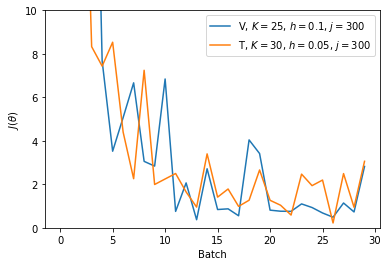

In [116]:
plt.plot(JθV, label=r'V, $K={}$, $h={}$, $j={}$'
         ''.format(sgdAdamOptV.M.K, sgdAdamOptV.M.h, sgdAdamOptV.maxiter))
plt.plot(JθT, label=r'T, $K={}$, $h={}$, $j={}$'
         ''.format(sgdAdamOptT.M.K, sgdAdamOptT.M.h, sgdAdamOptT.maxiter))
plt.legend()
plt.ylabel(r'$J(\theta)$')
plt.xlabel('Batch')
plt.ylim(0, 10)
plt.show()

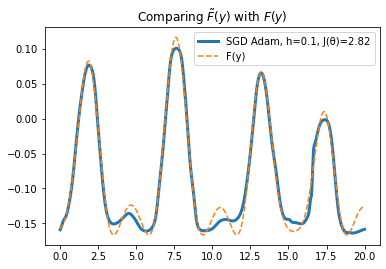

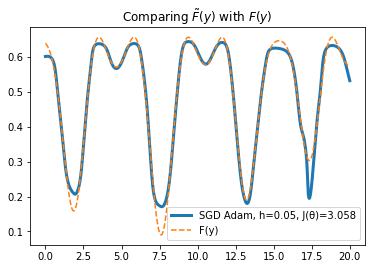

In [117]:
"""Show approximation to the last trained data"""
batchLast = batch = generate_data(batchTo)
CV = batchLast['V'][dataPointsFrom:dataPointsTo]
CT = batchLast['T'][dataPointsFrom:dataPointsTo]
t = batchLast['t'][dataPointsFrom:dataPointsTo]
plotApprox(CV, sgdAdamOptV, x=t)
plotApprox(CT, sgdAdamOptT, x=t)

By having "X" iterations on training batches one can se an apparent approximation to the excact output.

## (g) Test on untrained data batch

In [110]:
# Setup
testBatch = generate_data(batchTo+1)
Y0testQ = testBatch['Q']
CtestV = testBatch['V']
Y0testP = testBatch['P']
CtestT = testBatch['T']
ttest = testBatch['t']

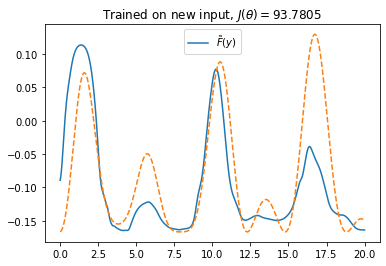

In [111]:
testOnNew(Y0testQ, CtestV, ttest, sgdAdamOptV)

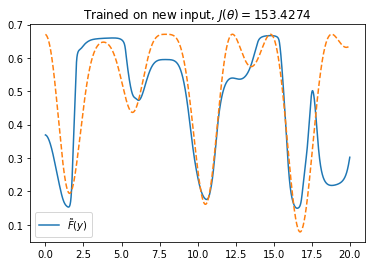

In [118]:
testOnNew(Y0testP, CtestT, ttest, sgdAdamOptT)

It is discovered that by training the model for too many iterations it gets to specific for the last training set. Thus, when given a new and unknown Hamiltonian, the model gives an approximation worse than if it is trained with fever iterations. This is corrected by doing a quick sweep through the data set with less itereations or simply by not having too many iterations in the first place.

# 3. Computing gradient of the trained function
This function is implemented in the Model class as a member function  "getGrads".

# 4. Computing gradient of the numerical Hamiltonian solution

In [32]:

# gradient of Hamiltonian in non linear pendelum
# The first coordinate returned is the deriate of T 
# with respect to p and the second V with respect to q
def grad1(qn, pn):
    return pn, m*g*l*np.sin(qn)

# gradient of Hamiltonian in Kepler two-body problem for a specific q and p
# dp_1. The derivate of T. dq_1 is the derivate of V. both with two coordinates


def grad2(qn, pn):
    dT = np.zeros(2)  # dT=dT/dp a 2x1 vector
    dV = np.zeros(2)  # dV=dV/dq a 2x1 vector
    dT[0] = pn[0]  # dT[0]=p_1
    dT[1] = pn[1]  # dT[1]=p_2
    dV[0] = (qn[0])/((qn[0]**2+qn[1]**2)**(3/2))  # dV[0]
    dV[1] = ((qn[1])/((qn[0]**2+qn[1]**2)**(3/2)))
    return dT, dV

# gradient of Hamiltonian in Henon-heiles problem


def grad3(qn, pn):
    dT = np.zeros(2)  # dT=dT/dp a 2x1 vector
    dV = np.zeros(2)  # dV=dV/dp a 2x1 vector
    dT[0] = pn[0]  # dT[0]=p_1
    dT[1] = pn[1]  # dT[1]=p_2
    dV[0] = qn[0]+2*qn[0]*qn[1]  # dV[0]
    dV[1] = qn[1]+qn[0]**2-qn[1]**2  # dV[0]
    return dT, dV

# 5. Functions for symplectic Euler and the Størmer-Verlet method for the Hamiltonian function

In [33]:
def symEuler(tot_t, T, V, q0, p0, h, grad1, grad2, grad, dim, trained):
    # t, T, V, ... , gradV=None, gradT=None, gradFunc=None
    # dimension
    # A stores the values of q and p. qn=A[0], pn=A[1]
    if dim > 1:
        A = np.zeros((2, N+1, dim))
    if dim == 1:
        A = np.zeros((2, N+1))
    A[0, 0], A[1, 0] = q0, p0  # Set the start values.
    # Memory allocation
    t = np.zeros((N+1))  # list of the time values
    H = np.zeros((N+1))  # list of the Hamiltonians
    Vlist = np.zeros((N+1))  # list of potensial energy
    Tlist = np.zeros((N+1))  # list if kinteic energy
    Vlist[0] = V(A[0, 0])  # set the start potensial energy
    Tlist[0] = T(A[1, 0])  # Set the start kinteic energy
    H[0] = Tlist[0]+Vlist[0]  # Set the first hamiltonian H[0]
    for n in range(N):
        qn, pn = A[0, n], A[1, n]  # Set the values of qn, and pn
        if trained == 0:
            dp = grad(qn, pn)[0]  # dT/dp
        else:
            dp = grad1[1, n]
        A[0, n+1] = A[0, n]+h*dp  # Set q_n+1
        qn1 = A[0, n+1]  # qn_n+1
        if trained == 0:
            dq1 = grad(qn1, pn)[1]
        else:
            dq1 = grad2[0, n+1]
        A[1, n+1] = A[1, n]-h*dq1  # Set p_n+1

        t[n+1] = (n+1)*h  # the next time value
        Vlist[n+1] = V(A[0, n+1])  # Next value of V
        Tlist[n+1] = T(A[1, n+1])  # Next value of T
        H[n+1] = Tlist[n+1]+Vlist[n+1]  # Calculate the next H=T+V
    return A, t, H, Vlist


def symEulerOpt(h, q0, p0, gradT, gradV):
    num_p = [p0]
    num_q = [q0]
    for n in range(len(gradT)):
        num_q.append(num_q[n] + h * gradT[n])
        num_p.append(num_p[n] - h * gradV[n])
    return num_q, num_p


### Størmer verlet ###
### similar to symplectic euler except with the extra step p_(n+1/2) ###

def Stormer_verlet(tot_t, T, V, q0, p0, h, grad, dim):
    if dim == 1:
        A = np.zeros((2, N+1))
    if dim > 1:
        A = np.zeros((2, N+1, dim))  # A[0]=qn values A[1]=pn values
    A[0, 0], A[1, 0] = q0, p0
    t = np.zeros((N+1))
    H = np.zeros((N+1))
    Vlist = np.zeros((N+1))
    Tlist = np.zeros((N+1))
    Vlist[0] = V(A[0, 0])
    Tlist[0] = T(A[1, 0])
    H[0] = Tlist[0]+Vlist[0]
    for n in range(N):
        qn, pn = A[0, n], A[1, n]
        dq = grad(qn, pn)[1]
        pn_12 = pn-(h/2)*dq  # T p_(n+1/2)
        dp_12 = grad(qn, pn_12)[0]
        A[0, n+1] = qn+h*dp_12
        qn1 = A[0, n+1]
        dqn1 = grad(qn1, pn)[1]
        A[1, n+1] = pn_12-(h/2)*dqn1
        t[n+1] = (n+1)*h
        t[n+1] = (n+1)*h
        Vlist[n+1] = V(A[0, n+1])
        Tlist[n+1] = T(A[1, n+1])
        H[n+1] = Tlist[n+1]+Vlist[n+1]
    return A, t, H, Vlist

## (a) Test on given Hamiltonians

## (b) Is the Hamiltonian preserved along the trajectories

## (c) Test on given data with unknown Hamiltonian